### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [15]:
# import sys
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/IntProject')

In [16]:
# del sys.modules['data_func']
import sys
# del sys.modules['model']


In [17]:
import torch
import copy
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample,DoubleConv,OutConv,UpSample,UNet
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F
os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A

from torch.cuda.amp import autocast, GradScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [ ]:
# pip install tqdm

In [ ]:
# pip install torchvision

### Data Preparation & Augmentation

In [4]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

In [18]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomResizedCrop(256, 256, scale=(0.8, 1.0), p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [19]:
run_colab = False
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True,num_workers=2)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True,num_workers=2)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask', None)
    testloader = torch.utils.data.DataLoader(val_set, batch_size=test_batch_size, shuffle=True,num_workers=2)
else:
    train_set = ImageDataset('./train/', './train_mask', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True,num_workers=2)
    val_set = ImageDataset('./val/', './val_mask', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True,num_workers=2)
    test_set = ImageDataset('./test/', './test_mask', None)
    testloader = torch.utils.data.DataLoader(val_set, batch_size=test_batch_size, shuffle=True,num_workers=2)

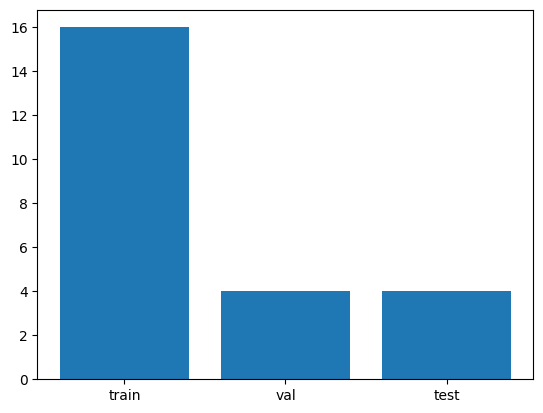

In [20]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

Traceback (most recent call last):
  File "/opt/miniconda3/envs/IntProject/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/miniconda3/envs/IntProject/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/miniconda3/envs/IntProject/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/miniconda3/envs/IntProject/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/miniconda3/envs/IntProject/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/opt/miniconda3/envs/IntProject/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/miniconda3/envs/IntProject/lib/python3.8/multiprocessing/connection.py", line 361, in 

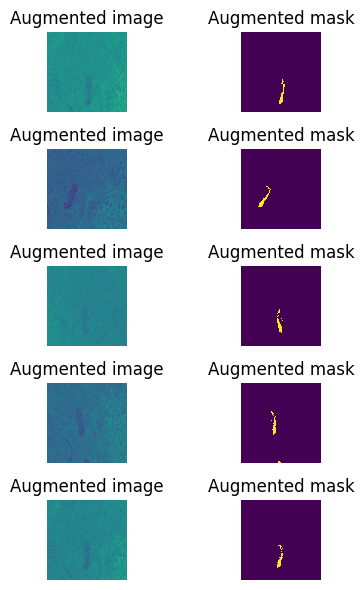

In [21]:
visualize_augmentations(train_set, idx=1, samples=5)


#### Train & Evaluate

In [22]:

class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceBCELoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        intersection = 2*(logits * targets).sum() + self.smooth
        union = (logits + targets).sum() + self.smooth
        dice_loss = 1. - intersection / union

        loss = nn.BCELoss()
        bce_loss = loss(logits, targets)

        return dice_loss + bce_loss

def dice_coeff(logits, targets):
    intersection = 2*(logits * targets).sum()
    union = (logits + targets).sum()
    if union == 0:
        return 1
    dice_coeff = intersection / union
    return dice_coeff.item()


def iou(logits, targets, smooth = 1):
    intersection = 2*(logits * targets).sum()
    union = (logits + targets).sum() - intersection
    if union == 0:
        return 1
    iou = intersection / union

    return iou.item()

def pixel_accuracy(logits, targets):
    preds = (logits > 0.5).float()
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)

    correct = torch.sum(preds_flat == targets_flat)
    total_pixels = targets_flat.numel()
    accuracy = correct.float() / total_pixels

    return accuracy.item()


In [23]:
def train(model, trainloader, optimizer, loss, epochs=10):
    train_losses, val_losses = [], []
    train_dices, val_dices = [], []
    train_ious, val_ious = [], []
    train_accs, val_accs = [], []
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        train_dice = 0
        train_iou = 0
        train_acc = 0
        for i, (images, masks) in enumerate(trainloader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            logits = model(images)
            l = loss(logits, masks)
            l.backward()
            optimizer.step()
            train_loss += l.item()
            train_dice += dice_coeff(logits, masks)
            train_iou += iou(logits, masks)
            train_acc += pixel_accuracy(logits, masks)
        train_loss /= len(trainloader)
        train_dice /= len(trainloader)
        train_iou /= len(trainloader)
        train_acc /= len(trainloader)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        train_ious.append(train_iou)
        train_accs.append(train_acc)

        #Validation
        model.eval()
        val_loss = 0
        val_dice = 0
        val_iou = 0
        val_acc = 0
        with torch.no_grad():
            for i, (images, masks) in enumerate(valloader):
                images, masks = images.to(device), masks.to(device)
                logits = model(images)
                l = loss(logits, masks)
                val_loss += l.item()
                val_dice += dice_coeff(logits, masks)
                val_iou += iou(logits, masks)
                val_acc += pixel_accuracy(logits, masks)
        val_loss /= len(valloader)
        val_dice /= len(valloader)
        val_iou /= len(valloader)
        val_acc /= len(valloader)
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        val_ious.append(val_iou)
        val_accs.append(val_acc)
        print(f"Epoch: {epoch + 1}  Train Loss: {train_loss:.4f} | Train DICE Coeff: {train_dice:.4f}  | Train IoU Coeff: {train_iou:.4f}|  | Train Accuracy: {train_acc * 100:.2f} | Val Loss: {val_loss:.4f} | Val DICE Coeff: {val_dice:.4f} | Val IoU Coeff: {val_iou:.4f}| Val Accuracy: {val_acc* 100:.2f}| ")

    return train_losses, train_dices, val_losses, val_dices

In [25]:
epochs = 50
loss = DiceBCELoss()
model = UNet(1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, train_dices, val_losses, val_dices = train(model, trainloader, optimizer, loss, epochs)

  0%|          | 0/50 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
images, masks = next(iter(testloader))
with torch.no_grad():
    pred = model(images.to(device)).cpu().detach()
    pred = pred > 0.5

def display_batch(images, masks, pred):
    images = images.permute(0, 2, 3, 1)
    masks = masks.permute(0, 2, 3, 1)
    pred = pred.permute(0, 2, 3, 1)

    images = images.numpy()
    masks = masks.numpy()
    pred = pred.numpy()

    images = np.concatenate(images, axis=1)
    masks = np.concatenate(masks, axis=1)
    pred = np.concatenate(pred, axis=1)

    fig, ax = plt.subplots(3, 1, figsize=(20, 6))
    fig.tight_layout()
    ax[0].imshow(images)
    ax[0].set_title('Images')
    ax[1].imshow(masks, cmap= 'gray')
    ax[1].set_title('Masks')
    ax[2].imshow(pred, cmap= 'gray')
    ax[2].set_title('Predicted Masks')

display_batch(images, masks, pred)

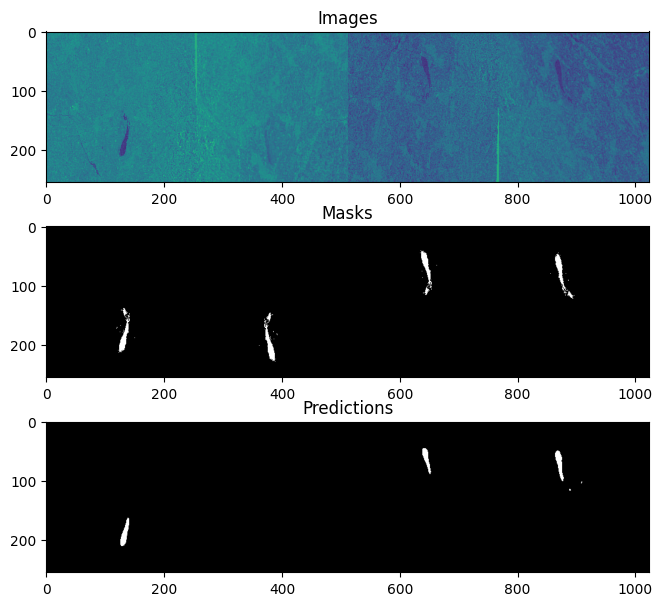